In [3]:
from argparse import ArgumentParser
# from snewpy import to_snowglobes
# from snewpy import run_snowglobes
# from snewpy import from_snowglobes
from snewpy import snowglobes
import tarfile
import numpy as np
import os
from astropy.io import ascii
from astropy import units as u
import matplotlib.pyplot as plt

home_directory = os.getcwd()
SNOwGLoBES_path = "/path/to/snowglobes/" #where snowglobes is located
SNEWPY_models_base = "/path/to/snewpy/models/" #where models (aka input for to_snowglobes) is located

In [10]:
#set distance in kpc
distance=10

#set SNOwGLoBES detector to use
detector = "icecube"

#set SNEWPY model type and filename
modeltype = 'Zha_2021'
modeldir = SNEWPY_models_base+"/"+modeltype+"/"
model = 's17'
filename = model+'.dat'

#set desired oscillation prescription
transformation = 'AdiabaticMSW_NMO'

#to_snowglobes creates a tarred file of snowglobes fluences
#this is stored in the model types directory in the snewpy/models
#the full path is returned from to_snowglobes
outfile = modeltype+"_"+model+"_"+transformation

#to_snowglobes.generate_fluence integrates the model over the
#specified time window(s) and generates fluence files for snowglobes

#Option 1 - don't specify tstart and tend, then the whole model is integrated
#tstart = None
#tend = None

#Option 2 - specify single tstart and tend, this makes 1 fluence file integrated over the windown
#tstart = 0.7 *u.s
#tend= 0.8 *u.s

#Option 3 = specify sequence of time intervals, one fluence
#file is made for each elements with dt=tstart[i]-tend[i]
window_tstart = 0.742
window_tend = 0.762
window_bins = 60
tstart = np.linspace(window_tstart,window_tend,window_bins,endpoint=False)*u.s
tend = tstart + (window_tend-window_tstart)/window_bins*u.s
tmid = (tstart+tend)*0.5

#call to_snowglobes
#There are two options, here we use generate_fluence
print("Preparing fluences...")
# tarredfile = to_snowglobes.generate_fluence(modeldir, filename, modeltype, transformation, distance, outfile,tstart,tend)
tarredfile = snowglobes.generate_fluence(modeldir, filename, modeltype, transformation, distance, outfile,tstart,tend)
print("Done fluences...")

print("Running snowglobes...")
#now run snowglobes, this will loop over all the fluence files in `tarredfile`
# run_snowglobes.go(SNOwGLoBES_path, modeldir, tarredfile, detector_input=detector,verbose=False)
snowglobes.go(SNOwGLoBES_path, modeldir, tarredfile, detector_input=detector,verbose=False)
print("Done snowglobes...")

#now collate results of output of snowglobes
print("Collating...")
# tables = from_snowglobes.collate(SNOwGLoBES_path, modeldir, tarredfile, detector_input=detector,skip_plots=True,return_tables=True,verbose=False)
tables = snowglobes.collate(SNOwGLoBES_path, modeldir, tarredfile, detector_input=detector,skip_plots=True,return_tables=True,verbose=False)

Preparing fluences...
Done fluences...
Running snowglobes...
Calculations are 10.0% completed. ( 6  of  60 )
Calculations are 20.0% completed. ( 12  of  60 )
Calculations are 30.0% completed. ( 18  of  60 )
Calculations are 40.0% completed. ( 24  of  60 )
Calculations are 50.0% completed. ( 30  of  60 )
Calculations are 60.0% completed. ( 36  of  60 )
Calculations are 70.0% completed. ( 42  of  60 )
Calculations are 80.0% completed. ( 48  of  60 )
Calculations are 90.0% completed. ( 54  of  60 )
Calculations are 100.0% completed. ( 60  of  60 )
Done snowglobes...
Collating...


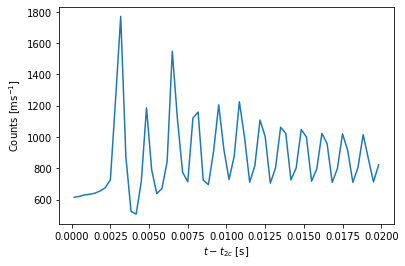

Total Events: 17459.043127709498


In [15]:
nevents = np.zeros(len(tmid))
for i in range(len(tmid)):
    key = "Collated_"+outfile+"_"+str(i)+"_"+detector+"_events_smeared_weighted.dat"
    for j in range(1,len(tables[key]['header'].split())):
        nevents[i] += sum(tables[key]['data'][j])

#nevents is per bin, convert to per ms
factor = window_bins/(window_tend-window_tstart)/1000.

plt.plot(tmid-0.742*u.s,nevents*factor)
plt.xlabel("$t-t_{2c}$ [s]")
plt.ylabel("Counts [ms$^{-1}$]")
plt.show()
#compare to Figure 5 of Zha et al. (2021)
print("Total Events:",sum(nevents))